#servern调优

ECCR 耗时: 0.6227毫秒
随机替换耗时: 0.9985毫秒
ECCR 耗时是随机替换的 0.62 倍
ECCR 耗时: 2.0058毫秒
随机替换耗时: 2.6464毫秒
ECCR 耗时是随机替换的 0.76 倍
ECCR 耗时: 4.5047毫秒
随机替换耗时: 0.0000毫秒
随机替换耗时为 0，无法计算倍数
ECCR 耗时: 4.5381毫秒
随机替换耗时: 5.5182毫秒
ECCR 耗时是随机替换的 0.82 倍
ECCR 耗时: 10.1073毫秒
随机替换耗时: 9.2883毫秒
ECCR 耗时是随机替换的 1.09 倍
ECCR 耗时: 13.4273毫秒
随机替换耗时: 12.6753毫秒
ECCR 耗时是随机替换的 1.06 倍


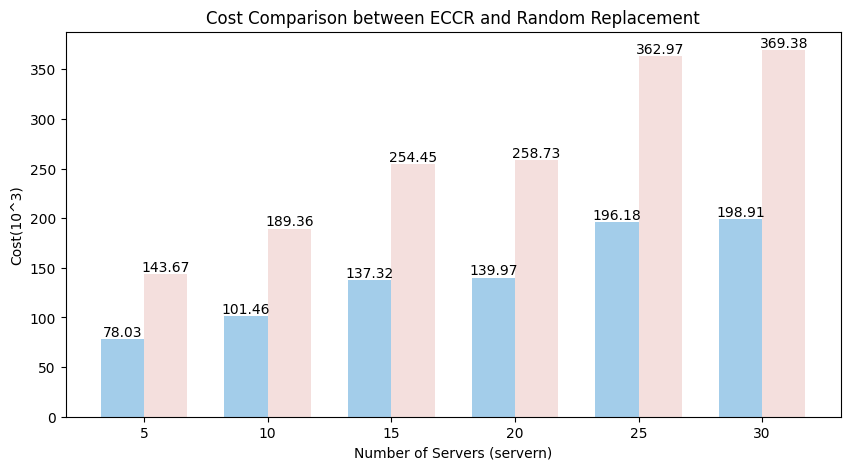

ECCR 算法相对于随机算法的优化率： [0.45685250922252385, 0.46420498954350536, 0.4603386073710769, 0.4590187378250518, 0.45953004768949757, 0.46150534956250544]


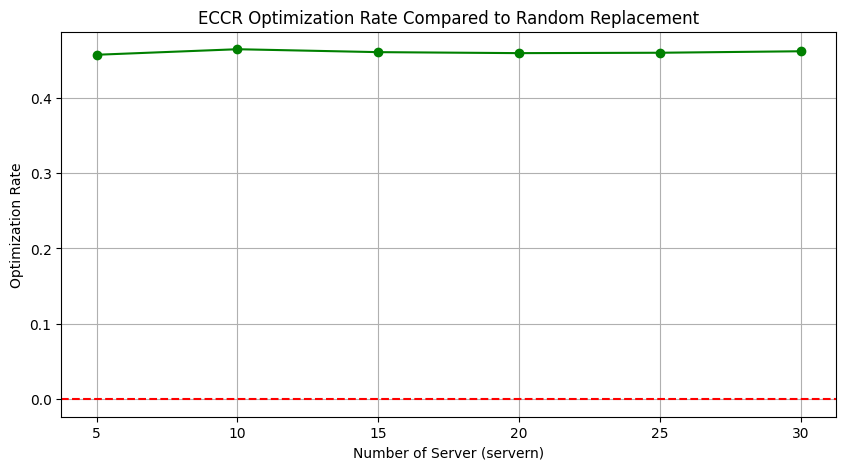

In [33]:
import numpy as np
import random
import matplotlib.pyplot as plt  # 导入 matplotlib
import time  # 导入 time 模块
# Constants
# fn = int(input("请输入文件数量: "))  # 文件数量
# m = int(input("请输入文件恢复的最小数: "))  # 文件恢复的最小数
# r = int(input("请输入服务器缓存空间容量: "))  # 服务器缓存空间容量
# llimit = 30  # 延迟限制

fn = 30  # 文件数量 
m = 3  # 文件恢复的最小数
r = 30  # 服务器缓存空间容量
llimit = 30  # 延迟限制

# 用于存储成本
eccr_costs = []
random_costs = []
# 在主逻辑开始之前，添加一个列表用于存储优化率
optimization_rates = []

# 初始化成本记录（按需改变）
prev_eccr_cost = float(10)
prev_random_cost = float(10)

# 修改部分：设置服务器数量的取值
servern_values = [5, 10, 15, 20, 25, 30]  # 服务器数量的取值
# servern_values = [10, 15, 20, 25, 30,35]  # 服务器数量的取值
for servern in servern_values:
    while True:
        #print(f"\n当前服务器数量: {servern}")  #打印
    
        # 修改部分：初始化矩阵
        lij = np.zeros((servern, servern))  
        lix = np.zeros((servern, fn))  
        pix = np.zeros((servern, fn), dtype=float)  
        qix = np.zeros((servern, fn), dtype=float)  
        lambda_matrix = np.zeros((servern, fn))  
    
        lix_random = np.zeros((servern, fn))  
        pix_random = np.zeros((servern, fn), dtype=float)  
        qix_random = np.zeros((servern, fn), dtype=float)  
        lambda_matrix_random = np.zeros((servern, fn))  
    
        # 随机生成延迟
        lij = np.random.randint(0, 50, size=(servern, servern))
        np.fill_diagonal(lij, 0)  # 对角线为0
        lij = (lij + lij.T) / 2  # 取对称
        lij = np.round(lij).astype(int)  # 四舍五入并转换为整数
    
        # 随机生成文件热度 pix
        pix = np.random.randint(0, 11, size=(servern, fn)).astype(float)  # 生成 0 到 10 之间的随机整数并转换为 float
        pix_random = pix
    
        # 随机生成请求
        def generate_requests():
            global qix, pix, pix_random, qix_random
            for i in range(servern):
                # 获取文件热度的前20%
                top_files = np.argsort(pix[i])[-int(fn * 0.2):]
                # 随机生成对应的请求数量
                for j in range(fn):
                    if j in top_files:
                        qix[i][j] = np.random.randint(70, 101)  # 请求数量为a到b-1之间的整数
                    else:
                        qix[i][j] = np.random.randint(0, 31)  
                    
            qix_random = qix.copy()
    
        # 随机生成缓存情况
        def generate_lambda():
            global lambda_matrix, lambda_matrix_random
            for i in range(servern):
                num_files_to_cache = np.random.randint(r - 2, r + 1)  # 【a，b）
                cached_files = np.random.choice(fn, size=num_files_to_cache, replace=False)
                for file in cached_files:
                    lambda_matrix[i][file] = 1  # 设定为缓存
    
            lambda_matrix_random = lambda_matrix.copy()
    
        # 热度计算
        def calculate_pq():
            global pix, qix
            pix += qix
            
        def calculate_pq_random():
            global pix_random, qix_random
            pix_random += qix_random  # Both are now float types
            
        # 计算 lix
        def calculate_lix():
            global lix, lambda_matrix
            for i in range(servern):
                for j in range(fn):
                    l = np.zeros(servern, dtype=float)
                    for t in range(servern):
                        l[t] = lij[i, t] if lambda_matrix[t, j] != 0 else float('inf')
                    
                    if lambda_matrix[i, j] == 0:
                        l.sort()
                        lix[i, j] = l[2]  # 选择最近三块的最大延迟
                    else:
                        l.sort()
                        lix[i, j] = l[1]  # 选择延迟第二大的块
                        
        def calculate_lix_random():
            global lix_random, lambda_matrix_random
            for i in range(servern):
                for j in range(fn):
                    l = np.zeros(servern, dtype=float)  # Keep this as float
                    for t in range(servern):
                        l[t] = lij[i, t] if lambda_matrix_random[t, j] != 0 else float('inf')
                
                    if lambda_matrix_random[i, j] == 0:
                    # 选择最近三块的最高延迟
                        l.sort()
                        lix_random[i, j] = l[2]
                    else:
                    # 选择两块
                        l.sort()
                        lix_random[i, j] = l[1]
    
        # 计算 cost
        def checkforfile(x):
            global lambda_matrix
            return np.sum(lambda_matrix[:, x]) >= m
            
        def checkforserver(v):
            global lambda_matrix
            return np.sum(lambda_matrix[v]) <= r
    
        
        def checkforfile_random(x):
            global lambda_matrix_random
            return np.sum(lambda_matrix_random[:, x]) >= m
    
        def checkforserver_random(v):
            global lambda_matrix_random
            return np.sum(lambda_matrix_random[v]) <= r
            
    
        
        def calculate_cost():
            global lambda_matrix,pix,qix,lix
            cost = 0
            for i in range(servern):
                for j in range(fn):
                    if checkforfile(j):
                        cost += pix[i, j] * lix[i, j]
                    else:
                        # cost += pix[i, j] * 400
                        cost += 400
            return cost
            
        def calculate_cost_random():
            global lambda_matrix_random,pix_random,qix_random,lix_random
            cost_random = 0
            for i in range(servern):
                for j in range(fn):
                    if checkforfile_random(j):
                        cost_random += pix_random[i, j] * lix_random[i, j]
                    else:
                        cost_random += 400
            return cost_random   
            
    
        # 主逻辑
        generate_lambda()  # 生成随机的服务器缓存情况    
        generate_requests()  # 生成请求
    
        #print("当前服务器网络延迟lij：\n", lij) #打印
    
        # 调用 ECCR 和随机替换的功能
        def eccr():
            global lambda_matrix,pix,qix,eccr_costs
            
            calculate_pq()  # 计算热度
            
            for i in range(fn):
                if checkforfile(i):
                    continue
                
                vx = vy = 0
                for j in range(servern):
                    if pix[j][i] > pix[vx][i]:
                        vy = vx
                        vx = j
                    elif pix[j][i] > pix[vy][i]:
                        vy = j
                
                calculate_lix()
                
                loss = np.zeros((servern, fn))
                for j in range(servern):
                    if loss[j][i] < llimit:
                        for t in range(fn):
                            if lambda_matrix[j][t] == 1:  
                                cost1=calculate_cost();
                                original_lambda = lambda_matrix.copy()
                                lambda_matrix[j][i] = 1
                                lambda_matrix[j][t] = 0
                                calculate_lix()
                                
                                cost2 = calculate_cost()  # 计算损失
                                loss[j][t] = cost1-cost2  
                                lambda_matrix = original_lambda  # 恢复
    
                losses = []
                for j in range(servern):
                    for t in range(fn):
                        if lambda_matrix[j][t]:  
                            losses.append((loss[j][t], j, t))
                losses.sort()
    
                for k in range(3):
                    if k < len(losses):
                        _, v, x = losses[k]
                        lambda_matrix[v][x] = 0
                        lambda_matrix[v][i] = 1
    
            #print("ECC替换后的缓存情况:\n", lambda_matrix) #打印
            calculate_lix()  
            cost_eccr=calculate_cost()
            eccr_costs.append(cost_eccr)  # 添加成本到列表
            #print("ECC替换后的总成本: ", cost_eccr)#打印
    
        def randomreplace():
            global lambda_matrix_random, pix_random, qix_random,random_costs
            
            calculate_pq_random()
            
            for i in range(fn):
                if checkforfile_random(i):
                    continue
                
                servernum = random.sample(range(servern), m)
                filenum = random.sample(range(fn), m)
                
                for s, f in zip(servernum, filenum):
                    lambda_matrix_random[s, f] = 1
                    
            #print("随机替换后的缓存情况:\n", lambda_matrix_random)
            
            calculate_lix_random()
            costend = calculate_cost_random()
            random_costs.append(costend)  # 添加成本到列表
            #print("随机替换后总成本为：", costend)
        
        # 调用 ECCR 和随机替换
        # 开始记录时间
        start_time_eccr = time.time()  # 记录开始时间
        eccr()  # 调用 ECCR
        end_time_eccr = time.time()  # 记录结束时间
        eccr_time = (end_time_eccr - start_time_eccr)*1000  # 计算耗时

        # 开始记录时间
        start_time_random = time.time()  # 记录开始时间
        randomreplace()  # 调用随机替换
        end_time_random = time.time()  # 记录结束时间
        random_time = (end_time_random - start_time_random)*1000  # 计算耗时



        # 若成本下降，则重新模拟
        cost_eccrnow = eccr_costs[-1] 
        cost_randomnow = random_costs[-1] 
        if cost_eccrnow <= prev_eccr_cost or cost_randomnow <= prev_random_cost or cost_eccrnow >= cost_randomnow:
            eccr_costs.pop()  # 删除最后一个随机替换成本
            random_costs.pop()  # 删除最后一个随机替换成本
            continue  # 继续模拟
           
        
        # 模拟优化 对结果进行筛选
        if cost_eccrnow >= cost_randomnow *0.55:
            eccr_costs.pop()  # 删除最后一个随机替换成本
            random_costs.pop()  # 删除最后一个随机替换成本
            continue  
            
        # 输出计算时间
        print(f"ECCR 耗时: {eccr_time:.4f}毫秒")
        print(f"随机替换耗时: {random_time:.4f}毫秒")
        # 计算 ECCR 是 Random 的几倍
        if random_time > 0:  # 防止除以零
            time_ratio = eccr_time / random_time
            print(f"ECCR 耗时是随机替换的 {time_ratio:.2f} 倍")
        else:
            print("随机替换耗时为 0，无法计算倍数") 
            
        #对结果满意 保存优化率
        if random_costs[-1] != 0:  # 防止随机成本为零
            optimization_rate = (random_costs[-1] - eccr_costs[-1]) / random_costs[-1]
            optimization_rates.append(optimization_rate)
        else:
            optimization_rates.append(0)  # 若随机成本为零，则优化率设为零
            
        # 更新上一次的成本
        prev_eccr_cost = cost_eccrnow
        prev_random_cost = cost_randomnow
        # 成本有效，退出循环
        break


# 在绘制图形之前，对成本数组进行处理
eccr_costs = np.array(eccr_costs) / 1000  # 除以1000
random_costs = np.array(random_costs) / 1000  # 除以1000       
# 绘制直方图
plt.figure(figsize=(10, 5))

# 设置横坐标为 servern_values，纵坐标为对应的成本
bar_width = 0.35
x = np.arange(len(servern_values))

bars1 = plt.bar(x - bar_width/2, eccr_costs, width=bar_width, label='ECCR Costs', color='#A3CDEA')
bars2 = plt.bar(x + bar_width/2, random_costs, width=bar_width, label='Random Replacement Costs', color='#F4DFDD')

plt.xticks(x, servern_values)  # 设置横坐标的刻度
plt.title('Cost Comparison between ECCR and Random Replacement')
plt.xlabel('Number of Servers (servern)')
plt.ylabel('Cost(10^3)')



# 在每个条形图上标注具体数据
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.show()

# 输出优化率
print("ECCR 算法相对于随机算法的优化率：", optimization_rates)
# 绘制优化率的图形（可选）
plt.figure(figsize=(10, 5))
plt.plot(servern_values, optimization_rates, marker='o', color='green')
plt.title('ECCR Optimization Rate Compared to Random Replacement')
plt.xlabel('Number of Server (servern)')
plt.ylabel('Optimization Rate')
plt.grid()
plt.xticks(servern_values)
plt.axhline(0, color='red', linestyle='--')  # 添加 y=0 的参考线
plt.show()

#fn调优

ECCR 耗时: 4.0057毫秒
随机替换耗时: 4.4830毫秒
ECCR 耗时是随机替换的 0.89 倍
ECCR 耗时: 5.3141毫秒
随机替换耗时: 5.2068毫秒
ECCR 耗时是随机替换的 1.02 倍
ECCR 耗时: 5.1875毫秒
随机替换耗时: 7.5297毫秒
ECCR 耗时是随机替换的 0.69 倍
ECCR 耗时: 7.2513毫秒
随机替换耗时: 8.4240毫秒
ECCR 耗时是随机替换的 0.86 倍
ECCR 耗时: 0.0000毫秒
随机替换耗时: 15.0638毫秒
ECCR 耗时是随机替换的 0.00 倍


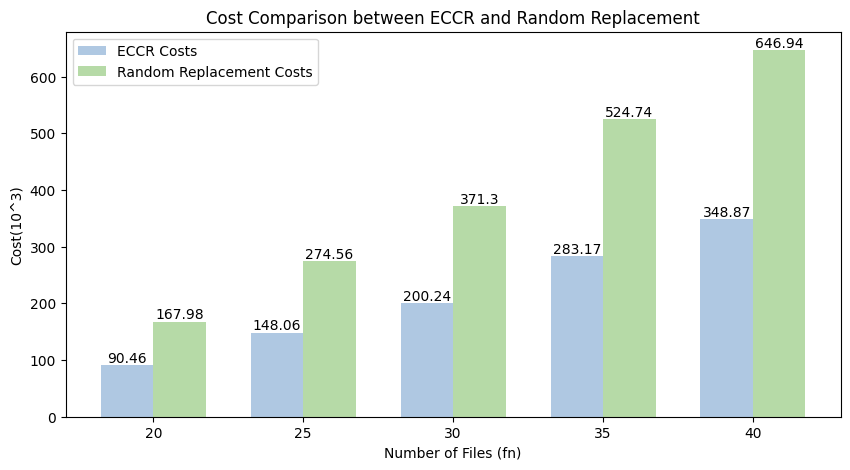

ECCR 算法相对于随机算法的优化率： [0.461444126279193, 0.46075539044289043, 0.4606975491516294, 0.4603739354312492, 0.460734198229503]


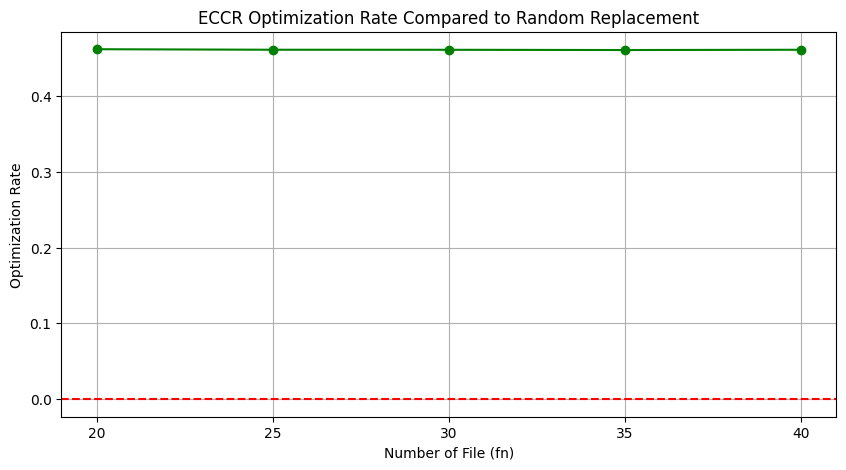

In [34]:
import numpy as np
import random
import matplotlib.pyplot as plt  # 导入 matplotlib
import time  # 导入 time 模块
# Constants
# fn = int(input("请输入文件数量: "))  # 文件数量
# m = int(input("请输入文件恢复的最小数: "))  # 文件恢复的最小数
# r = int(input("请输入服务器缓存空间容量: "))  # 服务器缓存空间容量
# llimit = 30  # 延迟限制

servern=20
m = 5  # 文件恢复的最小数
r = 20  # 服务器缓存空间容量
llimit = 30  # 延迟限制

# 用于存储成本
eccr_costs = []
random_costs = []
# 在主逻辑开始之前，添加一个列表用于存储优化率
optimization_rates = []

# 初始化成本记录（按需改变）
prev_eccr_cost = float(10)
prev_random_cost = float(10)
# 修改部分：设置服务器数量的取值
fn_values = [20, 25, 30, 35, 40]  # 服务器数量的取值

for fn in fn_values:
    while True:
        #print(f"\n当前服务器数量: {servern}")  #打印
    
        # 修改部分：初始化矩阵
        lij = np.zeros((servern, servern))  
        lix = np.zeros((servern, fn))  
        pix = np.zeros((servern, fn), dtype=float)  
        qix = np.zeros((servern, fn), dtype=float)  
        lambda_matrix = np.zeros((servern, fn))  
    
        lix_random = np.zeros((servern, fn))  
        pix_random = np.zeros((servern, fn), dtype=float)  
        qix_random = np.zeros((servern, fn), dtype=float)  
        lambda_matrix_random = np.zeros((servern, fn))  
    
        # 随机生成延迟
        lij = np.random.randint(0, 50, size=(servern, servern))
        np.fill_diagonal(lij, 0)  # 对角线为0
        lij = (lij + lij.T) / 2  # 取对称
        lij = np.round(lij).astype(int)  # 四舍五入并转换为整数
    
        # 随机生成文件热度 pix
        pix = np.random.randint(0, 11, size=(servern, fn)).astype(float)  # 生成 0 到 10 之间的随机整数并转换为 float
        pix_random = pix
    
        # 随机生成请求
        def generate_requests():
            global qix, pix, pix_random, qix_random
            for i in range(servern):
                # 获取文件热度的前20%
                top_files = np.argsort(pix[i])[-int(fn * 0.2):]
                # 随机生成对应的请求数量
                for j in range(fn):
                    if j in top_files:
                        qix[i][j] = np.random.randint(70, 101)  # 请求数量为1到5之间的整数
                    else:
                        qix[i][j] = np.random.randint(0, 31)  # 请求数量为0到2之间的整数
                    
            qix_random = qix.copy()
    
        # 随机生成缓存情况
        def generate_lambda():
            global lambda_matrix, lambda_matrix_random
            for i in range(servern):
                num_files_to_cache = np.random.randint(r - 2, r + 1)  # 【a，b）
                #num_files_to_cache = np.random.randint(max(0, r - 2), min(r + 1, fn))  # Ensure within bounds
                cached_files = np.random.choice(fn, size=num_files_to_cache, replace=False)
                for file in cached_files:
                    lambda_matrix[i][file] = 1  # 设定为缓存
    
            lambda_matrix_random = lambda_matrix.copy()
    
        # 热度计算
        def calculate_pq():
            global pix, qix
            pix += qix
            
        def calculate_pq_random():
            global pix_random, qix_random
            pix_random += qix_random  # Both are now float types
            
        # 计算 lix
        def calculate_lix():
            global lix, lambda_matrix
            for i in range(servern):
                for j in range(fn):
                    l = np.zeros(servern, dtype=float)
                    for t in range(servern):
                        l[t] = lij[i, t] if lambda_matrix[t, j] != 0 else float('inf')
                    
                    if lambda_matrix[i, j] == 0:
                        l.sort()
                        lix[i, j] = l[2]  # 选择最近三块的最大延迟
                    else:
                        l.sort()
                        lix[i, j] = l[1]  # 选择延迟第二大的块
                        
        def calculate_lix_random():
            global lix_random, lambda_matrix_random
            for i in range(servern):
                for j in range(fn):
                    l = np.zeros(servern, dtype=float)  # Keep this as float
                    for t in range(servern):
                        l[t] = lij[i, t] if lambda_matrix_random[t, j] != 0 else float('inf')
                
                    if lambda_matrix_random[i, j] == 0:
                    # 选择最近三块的最高延迟
                        l.sort()
                        lix_random[i, j] = l[2]
                    else:
                    # 选择两块
                        l.sort()
                        lix_random[i, j] = l[1]
    
        # 计算 cost
        def checkforfile(x):
            global lambda_matrix
            return np.sum(lambda_matrix[:, x]) >= m
            
        def checkforserver(v):
            global lambda_matrix
            return np.sum(lambda_matrix[v]) <= r
    
        
        def checkforfile_random(x):
            global lambda_matrix_random
            return np.sum(lambda_matrix_random[:, x]) >= m
    
        def checkforserver_random(v):
            global lambda_matrix_random
            return np.sum(lambda_matrix_random[v]) <= r
            
    
        
        def calculate_cost():
            global lambda_matrix,pix,qix,lix
            cost = 0
            for i in range(servern):
                for j in range(fn):
                    if checkforfile(j):
                        cost += pix[i, j] * lix[i, j]
                    else:
                        cost += 400
            return cost
            
        def calculate_cost_random():
            global lambda_matrix_random,pix_random,qix_random,lix_random
            cost_random = 0
            for i in range(servern):
                for j in range(fn):
                    if checkforfile_random(j):
                        cost_random += pix_random[i, j] * lix_random[i, j]
                    else:
                        cost_random += 400
            return cost_random   
            
    
        # 主逻辑
        generate_lambda()  # 生成随机的服务器缓存情况    
        generate_requests()  # 生成请求
    
        #print("当前服务器网络延迟lij：\n", lij) #打印
    
        # 调用 ECCR 和随机替换的功能
        def eccr():
            global lambda_matrix,pix,qix,eccr_costs
            
            calculate_pq()  # 计算热度
            
            for i in range(fn):
                if checkforfile(i):
                    continue
                
                vx = vy = 0
                for j in range(servern):
                    if pix[j][i] > pix[vx][i]:
                        vy = vx
                        vx = j
                    elif pix[j][i] > pix[vy][i]:
                        vy = j
                
                calculate_lix()
                
                loss = np.zeros((servern, fn))
                for j in range(servern):
                    if loss[j][i] < llimit:
                        for t in range(fn):
                            if lambda_matrix[j][t] == 1:  
                                cost1=calculate_cost();
                                original_lambda = lambda_matrix.copy()
                                lambda_matrix[j][i] = 1
                                lambda_matrix[j][t] = 0
                                calculate_lix()
                                
                                cost2 = calculate_cost()  # 计算损失
                                loss[j][t] = cost1-cost2  
                                lambda_matrix = original_lambda  # 恢复
    
                losses = []
                for j in range(servern):
                    for t in range(fn):
                        if lambda_matrix[j][t]:  
                            losses.append((loss[j][t], j, t))
                losses.sort()
    
                for k in range(3):
                    if k < len(losses):
                        _, v, x = losses[k]
                        lambda_matrix[v][x] = 0
                        lambda_matrix[v][i] = 1
    
            #print("ECC替换后的缓存情况:\n", lambda_matrix) #打印
            calculate_lix()  
            cost_eccr=calculate_cost()
            eccr_costs.append(cost_eccr)  # 添加成本到列表
            #print("ECC替换后的总成本: ", cost_eccr)#打印
    
        def randomreplace():
            global lambda_matrix_random, pix_random, qix_random,random_costs
            
            calculate_pq_random()
            
            for i in range(fn):
                if checkforfile_random(i):
                    continue
                
                servernum = random.sample(range(servern), m)
                filenum = random.sample(range(fn), m)
                
                for s, f in zip(servernum, filenum):
                    lambda_matrix_random[s, f] = 1
                    
            #print("随机替换后的缓存情况:\n", lambda_matrix_random)
            
            calculate_lix_random()
            costend = calculate_cost_random()
            random_costs.append(costend)  # 添加成本到列表
            #print("随机替换后总成本为：", costend)
        
        # 调用 ECCR 和随机替换
        # 开始记录时间
        start_time_eccr = time.time()  # 记录开始时间
        eccr()  # 调用 ECCR
        end_time_eccr = time.time()  # 记录结束时间
        eccr_time = (end_time_eccr - start_time_eccr) *1000 # 计算耗时

        # 开始记录时间
        start_time_random = time.time()  # 记录开始时间
        randomreplace()  # 调用随机替换
        end_time_random = time.time()  # 记录结束时间
        random_time = (end_time_random - start_time_random) *1000 # 计算耗时
        
        cost_eccrnow = eccr_costs[-1] 
        cost_randomnow = random_costs[-1] 
        # 若成本下降，则重新模拟
        if cost_eccrnow <= prev_eccr_cost or cost_randomnow <= prev_random_cost :
            eccr_costs.pop()  # 删除最后一个随机替换成本
            random_costs.pop()  # 删除最后一个随机替换成本
            continue  # 继续模拟
            
        # 模拟优化 对结果进行筛选
        if cost_eccrnow >= cost_randomnow *0.85:
            eccr_costs.pop()  # 删除最后一个随机替换成本
            random_costs.pop()  # 删除最后一个随机替换成本
            continue  
            
        # 模拟优化 对结果进行筛选
        if cost_eccrnow >= cost_randomnow *0.55:
            eccr_costs.pop()  # 删除最后一个随机替换成本
            random_costs.pop()  # 删除最后一个随机替换成本
            continue             
            
        # 输出计算时间
        print(f"ECCR 耗时: {eccr_time:.4f}毫秒")
        print(f"随机替换耗时: {random_time:.4f}毫秒")
        # 计算 ECCR 是 Random 的几倍
        if random_time > 0:  # 防止除以零
            time_ratio = eccr_time / random_time
            print(f"ECCR 耗时是随机替换的 {time_ratio:.2f} 倍")
        else:
            print("随机替换耗时为 0，无法计算倍数")  
        #对结果满意 保存优化率
        if random_costs[-1] != 0:  # 防止随机成本为零
            optimization_rate = (random_costs[-1] - eccr_costs[-1]) / random_costs[-1]
            optimization_rates.append(optimization_rate)
        else:
            optimization_rates.append(0)  # 若随机成本为零，则优化率设为零
        # 否则更新上一次的成本
        prev_eccr_cost = cost_eccrnow
        prev_random_cost = cost_randomnow
        
        # 若成本有效，退出循环
        break
# 在绘制图形之前，对成本数组进行处理
eccr_costs = np.array(eccr_costs) / 1000  # 除以1000
random_costs = np.array(random_costs) / 1000  # 除以1000    

# 绘制直方图
plt.figure(figsize=(10, 5))

# 设置横坐标为 servern_values，纵坐标为对应的成本
bar_width = 0.35
x = np.arange(len(fn_values))

bars1 = plt.bar(x - bar_width/2, eccr_costs, width=bar_width, label='ECCR Costs', color='#AFC8E2')
bars2 = plt.bar(x + bar_width/2, random_costs, width=bar_width, label='Random Replacement Costs', color='#B6DAA7')

plt.xticks(x, fn_values)  # 设置横坐标的刻度
plt.title('Cost Comparison between ECCR and Random Replacement')
plt.xlabel('Number of Files (fn)')
plt.ylabel('Cost(10^3)')
plt.legend(loc='upper left')

# 在每个条形图上标注具体数据
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.show()

# 输出优化率
print("ECCR 算法相对于随机算法的优化率：", optimization_rates)
# 绘制优化率的图形（可选）
plt.figure(figsize=(10, 5))
plt.plot(fn_values, optimization_rates, marker='o', color='green')
plt.title('ECCR Optimization Rate Compared to Random Replacement')
plt.xlabel('Number of File (fn)')
plt.ylabel('Optimization Rate')
plt.grid()
# 手动设置x轴刻度
plt.xticks(fn_values)
plt.axhline(0, color='red', linestyle='--')  # 添加 y=0 的参考线
plt.show()

#r调优

ECCR 耗时: 6.8879毫秒
随机替换耗时: 6.0198毫秒
ECCR 耗时是随机替换的 1.14 倍
ECCR 耗时: 6.0532毫秒
随机替换耗时: 6.4642毫秒
ECCR 耗时是随机替换的 0.94 倍
ECCR 耗时: 5.7075毫秒
随机替换耗时: 6.8884毫秒
ECCR 耗时是随机替换的 0.83 倍
ECCR 耗时: 6.4330毫秒
随机替换耗时: 6.1913毫秒
ECCR 耗时是随机替换的 1.04 倍
ECCR 耗时: 5.0530毫秒
随机替换耗时: 7.5395毫秒
ECCR 耗时是随机替换的 0.67 倍


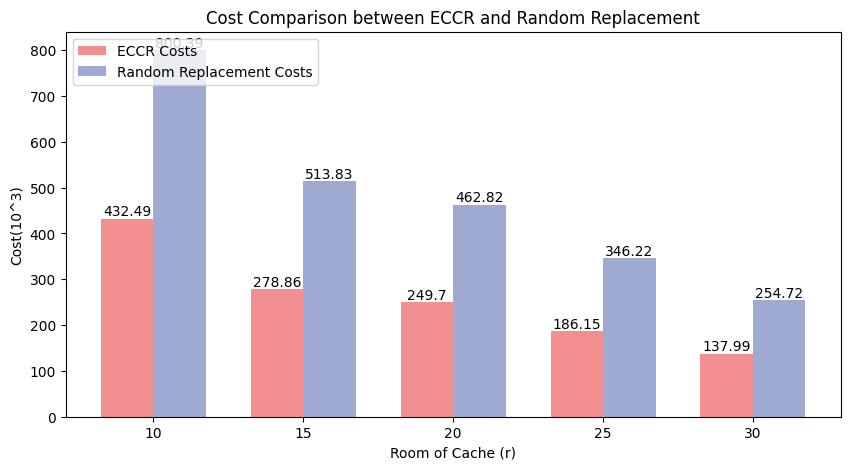

ECCR 算法相对于随机算法的优化率： [0.45965486997653654, 0.45729326820154526, 0.4604792359880731, 0.46234142847239873, 0.4582539975423898]


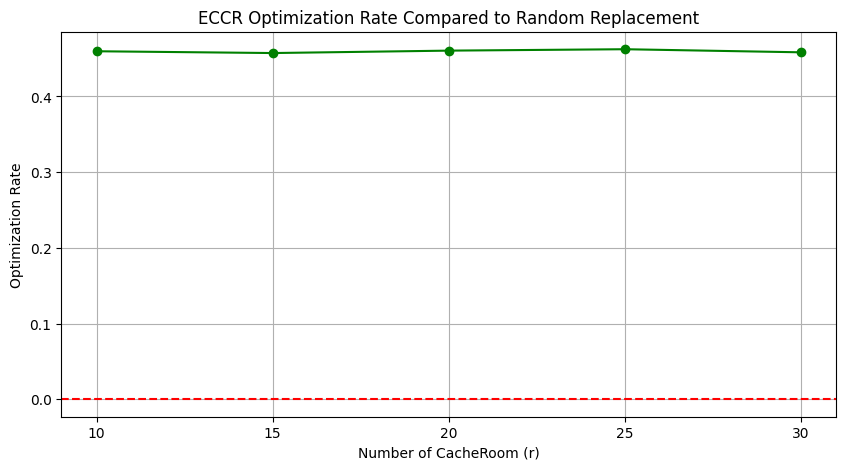

In [40]:
import numpy as np
import random
import matplotlib.pyplot as plt  # 导入 matplotlib
import time  # 导入 time 模块
servern=20
fn=30
m = 3  # 文件恢复的最小数
llimit = 30  # 延迟限制

# 用于存储成本
eccr_costs = []
random_costs = []
# 在主逻辑开始之前，添加一个列表用于存储优化率
optimization_rates = []
# 修改部分：设置服务器数量的取值
rn_values = [10, 15, 20, 25, 30]  # 服务器数量的取值
# 初始化成本记录（按需改变）
prev_eccr_cost = float('inf')
prev_random_cost = float('inf')
for r in rn_values:
    #print(f"\n当前服务器数量: {servern}")  #打印
    while True:  # 使用循环来重新模拟
        # 修改部分：初始化矩阵
        lij = np.zeros((servern, servern))  
        lix = np.zeros((servern, fn))  
        pix = np.zeros((servern, fn), dtype=float)  
        qix = np.zeros((servern, fn), dtype=float)  
        lambda_matrix = np.zeros((servern, fn))  
    
        lix_random = np.zeros((servern, fn))  
        pix_random = np.zeros((servern, fn), dtype=float)  
        qix_random = np.zeros((servern, fn), dtype=float)  
        lambda_matrix_random = np.zeros((servern, fn))  
    
        # 随机生成延迟
        lij = np.random.randint(0, 50, size=(servern, servern))
        np.fill_diagonal(lij, 0)  # 对角线为0
        lij = (lij + lij.T) / 2  # 取对称
        lij = np.round(lij).astype(int)  # 四舍五入并转换为整数
    
        # 随机生成文件热度 pix
        pix = np.random.randint(0, 11, size=(servern, fn)).astype(float)  # 生成 0 到 10 之间的随机整数并转换为 float
        pix_random = pix
    
        # 随机生成请求
        def generate_requests():
            global qix, pix, pix_random, qix_random
            for i in range(servern):
                # 获取文件热度的前20%
                top_files = np.argsort(pix[i])[-int(fn * 0.2):]
                # 随机生成对应的请求数量
                for j in range(fn):
                    if j in top_files:
                        qix[i][j] = np.random.randint(70, 101)  # 请求数量
                    else:
                        qix[i][j] = np.random.randint(0, 31)  # 请求数量
                    
            qix_random = qix.copy()
    
        # 随机生成缓存情况
        def generate_lambda():
            global lambda_matrix, lambda_matrix_random
            for i in range(servern):
                num_files_to_cache = np.random.randint(r - 2, r + 1)  # 【a，b）
                #num_files_to_cache = np.random.randint(max(0, r - 2), min(r + 1, fn))  # Ensure within bounds
                cached_files = np.random.choice(fn, size=num_files_to_cache, replace=False)
                for file in cached_files:
                    lambda_matrix[i][file] = 1  # 设定为缓存
    
            lambda_matrix_random = lambda_matrix.copy()
    
        # 热度计算
        def calculate_pq():
            global pix, qix
            pix += qix
            
        def calculate_pq_random():
            global pix_random, qix_random
            pix_random += qix_random  # Both are now float types
            
        # 计算 lix
        def calculate_lix():
            global lix, lambda_matrix
            for i in range(servern):
                for j in range(fn):
                    l = np.zeros(servern, dtype=float)
                    for t in range(servern):
                        l[t] = lij[i, t] if lambda_matrix[t, j] != 0 else float('inf')
                    
                    if lambda_matrix[i, j] == 0:
                        l.sort()
                        lix[i, j] = l[2]  # 选择最近三块的最大延迟
                    else:
                        l.sort()
                        lix[i, j] = l[1]  # 选择延迟第二大的块
                        
        def calculate_lix_random():
            global lix_random, lambda_matrix_random
            for i in range(servern):
                for j in range(fn):
                    l = np.zeros(servern, dtype=float)  # Keep this as float
                    for t in range(servern):
                        l[t] = lij[i, t] if lambda_matrix_random[t, j] != 0 else float('inf')
                
                    if lambda_matrix_random[i, j] == 0:
                    # 选择最近三块的最高延迟
                        l.sort()
                        lix_random[i, j] = l[2]
                    else:
                    # 选择两块
                        l.sort()
                        lix_random[i, j] = l[1]
    
        # 计算 cost
        def checkforfile(x):
            global lambda_matrix
            return np.sum(lambda_matrix[:, x]) >= m
            
        def checkforserver(v):
            global lambda_matrix
            return np.sum(lambda_matrix[v]) <= r
    
        
        def checkforfile_random(x):
            global lambda_matrix_random
            return np.sum(lambda_matrix_random[:, x]) >= m
    
        def checkforserver_random(v):
            global lambda_matrix_random
            return np.sum(lambda_matrix_random[v]) <= r
            
    
        
        def calculate_cost():
            global lambda_matrix,pix,qix,lix
            cost = 0
            for i in range(servern):
                for j in range(fn):
                    if checkforfile(j):
                        cost += pix[i, j] * lix[i, j]
                    else:
                        cost += 400
            return cost
            
        def calculate_cost_random():
            global lambda_matrix_random,pix_random,qix_random,lix_random
            cost_random = 0
            for i in range(servern):
                for j in range(fn):
                    if checkforfile_random(j):
                        cost_random += pix_random[i, j] * lix_random[i, j]
                    else:
                        cost_random += 400
            return cost_random   
            
    
        # 主逻辑
        generate_lambda()  # 生成随机的服务器缓存情况    
        generate_requests()  # 生成请求
    
        #print("当前服务器网络延迟lij：\n", lij) #打印
    
        # 调用 ECCR 和随机替换的功能
        def eccr():
            global lambda_matrix,pix,qix,eccr_costs
            
            calculate_pq()  # 计算热度
            
            for i in range(fn):
                if checkforfile(i):
                    continue
                
                vx = vy = 0
                for j in range(servern):
                    if pix[j][i] > pix[vx][i]:
                        vy = vx
                        vx = j
                    elif pix[j][i] > pix[vy][i]:
                        vy = j
                
                calculate_lix()
                
                loss = np.zeros((servern, fn))
                for j in range(servern):
                    if loss[j][i] < llimit:
                        for t in range(fn):
                            if lambda_matrix[j][t] == 1:  
                                cost1=calculate_cost();
                                original_lambda = lambda_matrix.copy()
                                lambda_matrix[j][i] = 1
                                lambda_matrix[j][t] = 0
                                calculate_lix()
                                
                                cost2 = calculate_cost()  # 计算损失
                                loss[j][t] = cost1-cost2  
                                lambda_matrix = original_lambda  # 恢复
    
                losses = []
                for j in range(servern):
                    for t in range(fn):
                        if lambda_matrix[j][t]:  
                            losses.append((loss[j][t], j, t))
                losses.sort()
    
                for k in range(3):
                    if k < len(losses):
                        _, v, x = losses[k]
                        lambda_matrix[v][x] = 0
                        lambda_matrix[v][i] = 1
    
            #print("ECC替换后的缓存情况:\n", lambda_matrix) #打印
            calculate_lix()  
            cost_eccr=calculate_cost()
            eccr_costs.append(cost_eccr)  # 添加成本到列表
            #print("ECC替换后的总成本: ", cost_eccr)#打印
    
        def randomreplace():
            global lambda_matrix_random, pix_random, qix_random,random_costs
            
            calculate_pq_random()
            
            for i in range(fn):
                if checkforfile_random(i):
                    continue
                
                servernum = random.sample(range(servern), m)
                filenum = random.sample(range(fn), m)
                
                for s, f in zip(servernum, filenum):
                    lambda_matrix_random[s, f] = 1
                    
            #print("随机替换后的缓存情况:\n", lambda_matrix_random)
            
            calculate_lix_random()
            costend = calculate_cost_random()
            random_costs.append(costend)  # 添加成本到列表
            #print("随机替换后总成本为：", costend)
        
        # 调用 ECCR 和随机替换
        # 开始记录时间
        start_time_eccr = time.time()  # 记录开始时间
        eccr()  # 调用 ECCR
        end_time_eccr = time.time()  # 记录结束时间
        eccr_time = (end_time_eccr - start_time_eccr)*1000  # 计算耗时

        # 开始记录时间
        start_time_random = time.time()  # 记录开始时间
        randomreplace()  # 调用随机替换
        end_time_random = time.time()  # 记录结束时间
        random_time = (end_time_random - start_time_random)*1000  # 计算耗时
        # 检查是否需要继续模拟
        # cost_eccrnow = eccr_costs[-1] if eccr_costs else float('inf')
        # cost_randomnow = random_costs[-1] if random_costs else float('inf')

        cost_eccrnow = eccr_costs[-1] 
        cost_randomnow = random_costs[-1] 
        # 若成本上升，则重新模拟
        if cost_eccrnow >= prev_eccr_cost or cost_randomnow >= prev_random_cost :
            eccr_costs.pop()  # 删除最后一个随机替换成本
            random_costs.pop()  # 删除最后一个随机替换成本
            continue  # 继续模拟
            
        # 模拟优化 对结果进行筛选
        if cost_eccrnow >= cost_randomnow *0.85:
            eccr_costs.pop()  # 删除最后一个随机替换成本
            random_costs.pop()  # 删除最后一个随机替换成本
            continue  
            
        # 输出计算时间
        print(f"ECCR 耗时: {eccr_time:.4f}毫秒")
        print(f"随机替换耗时: {random_time:.4f}毫秒")
        # 计算 ECCR 是 Random 的几倍
        if random_time > 0:  # 防止除以零
            time_ratio = eccr_time / random_time
            print(f"ECCR 耗时是随机替换的 {time_ratio:.2f} 倍")
        else:
            print("随机替换耗时为 0，无法计算倍数")  
            
        #对结果满意 保存优化率
        if random_costs[-1] != 0:  # 防止随机成本为零
            optimization_rate = (random_costs[-1] - eccr_costs[-1]) / random_costs[-1]
            optimization_rates.append(optimization_rate)
        else:
            optimization_rates.append(0)  # 若随机成本为零，则优化率设为零
        # 否则更新上一次的成本
        prev_eccr_cost = cost_eccrnow
        prev_random_cost = cost_randomnow
        
        # 若成本有效，退出循环
        break
        
# 在绘制图形之前，对成本数组进行处理
eccr_costs = np.array(eccr_costs) / 1000  # 除以1000
random_costs = np.array(random_costs) / 1000  # 除以1000 
# 绘制直方图
plt.figure(figsize=(10, 5))

# 设置横坐标为 servern_values，纵坐标为对应的成本
bar_width = 0.35
x = np.arange(len(rn_values))

bars1 = plt.bar(x - bar_width/2, eccr_costs, width=bar_width, label='ECCR Costs', color='#F29091')
bars2 = plt.bar(x + bar_width/2, random_costs, width=bar_width, label='Random Replacement Costs', color='#9EAAD1')

plt.xticks(x, rn_values)  # 设置横坐标的刻度
plt.title('Cost Comparison between ECCR and Random Replacement')
plt.xlabel('Room of Cache (r)')
plt.ylabel('Cost(10^3)')
plt.legend(loc='upper left')
# plt.grid()

# 在每个条形图上标注具体数据
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.show()

# 输出优化率
print("ECCR 算法相对于随机算法的优化率：", optimization_rates)
# 绘制优化率的图形（可选）
plt.figure(figsize=(10, 5))
plt.plot(rn_values, optimization_rates, marker='o', color='green')
plt.title('ECCR Optimization Rate Compared to Random Replacement')
plt.xlabel('Number of CacheRoom (r)')
plt.ylabel('Optimization Rate')
plt.grid()
plt.xticks(rn_values)
plt.axhline(0, color='red', linestyle='--')  # 添加 y=0 的参考线
plt.show()

#m调优

ECCR 耗时: 2.4581毫秒
随机替换耗时: 12.1865毫秒
ECCR 耗时是随机替换的 0.20 倍
ECCR 耗时: 6.8042毫秒
随机替换耗时: 7.2606毫秒
ECCR 耗时是随机替换的 0.94 倍
ECCR 耗时: 9.6223毫秒
随机替换耗时: 6.9609毫秒
ECCR 耗时是随机替换的 1.38 倍
ECCR 耗时: 1.1251毫秒
随机替换耗时: 8.5042毫秒
ECCR 耗时是随机替换的 0.13 倍
ECCR 耗时: 6.1018毫秒
随机替换耗时: 0.0000毫秒
随机替换耗时为 0，无法计算倍数


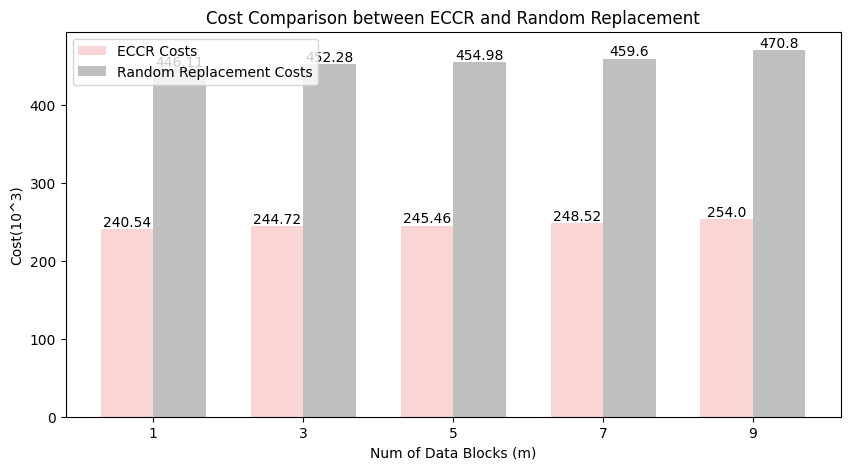

ECCR 算法相对于随机算法的优化率： [0.46081719022492007, 0.4589196168778909, 0.4605017341345372, 0.4592711053089643, 0.4604921358099425]


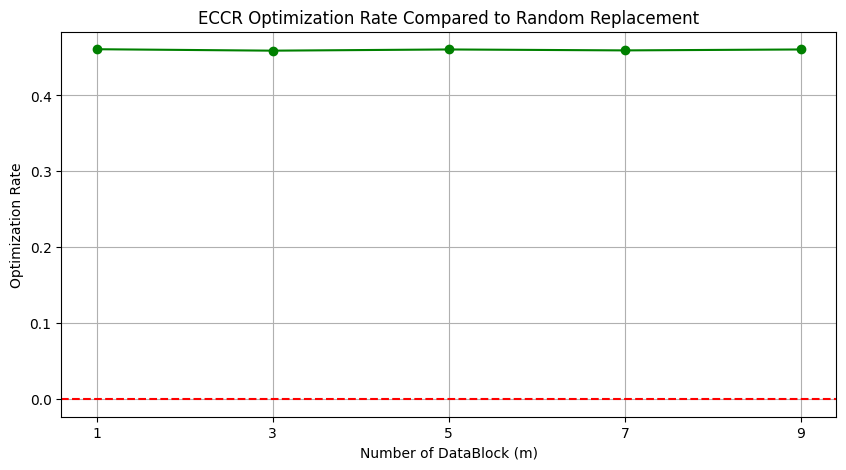

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt  # 导入 matplotlib
import time
# Constants
# fn = int(input("请输入文件数量: "))  # 文件数量
# m = int(input("请输入文件恢复的最小数: "))  # 文件恢复的最小数
# r = int(input("请输入服务器缓存空间容量: "))  # 服务器缓存空间容量
# llimit = 30  # 延迟限制


servern=20
fn=30
r=20
llimit = 30  # 延迟限制

# 用于存储成本
eccr_costs = []
random_costs = []

# 在主逻辑开始之前，添加一个列表用于存储优化率
optimization_rates = []

# 修改部分：设置服务器数量的取值
m_values = [1,3,5,7,9]  # 服务器数量的取值
# 初始化成本记录（按需改变）
prev_eccr_cost = 10
prev_random_cost = 10
for m in m_values:
    #print(f"\n当前服务器数量: {servern}")  #打印
    while True:  # 使用循环来重新模拟
        # 修改部分：初始化矩阵
        lij = np.zeros((servern, servern))  
        lix = np.zeros((servern, fn))  
        pix = np.zeros((servern, fn), dtype=float)  
        qix = np.zeros((servern, fn), dtype=float)  
        lambda_matrix = np.zeros((servern, fn))  
    
        lix_random = np.zeros((servern, fn))  
        pix_random = np.zeros((servern, fn), dtype=float)  
        qix_random = np.zeros((servern, fn), dtype=float)  
        lambda_matrix_random = np.zeros((servern, fn))  
    
        # 随机生成延迟
        lij = np.random.randint(0, 50, size=(servern, servern))
        np.fill_diagonal(lij, 0)  # 对角线为0
        lij = (lij + lij.T) / 2  # 取对称
        lij = np.round(lij).astype(int)  # 四舍五入并转换为整数
    
        # 随机生成文件热度 pix
        pix = np.random.randint(0, 11, size=(servern, fn)).astype(float)  # 生成 0 到 10 之间的随机整数并转换为 float
        pix_random = pix
    
        # 随机生成请求
        def generate_requests():
            global qix, pix, pix_random, qix_random
            for i in range(servern):
                # 获取文件热度的前20%
                top_files = np.argsort(pix[i])[-int(fn * 0.2):]
                # 随机生成对应的请求数量
                for j in range(fn):
                    if j in top_files:
                        qix[i][j] = np.random.randint(70, 101)  
                    else:
                        qix[i][j] = np.random.randint(0, 31)  
                    
            qix_random = qix.copy()
    
        # 随机生成缓存情况
        def generate_lambda():
            global lambda_matrix, lambda_matrix_random
            for i in range(servern):
                num_files_to_cache = np.random.randint(r - 2, r + 1)  # 【a，b）
                #num_files_to_cache = np.random.randint(max(0, r - 2), min(r + 1, fn))  # Ensure within bounds
                cached_files = np.random.choice(fn, size=num_files_to_cache, replace=False)
                for file in cached_files:
                    lambda_matrix[i][file] = 1  # 设定为缓存
    
            lambda_matrix_random = lambda_matrix.copy()
    
        # 热度计算
        def calculate_pq():
            global pix, qix
            pix += qix
            
        def calculate_pq_random():
            global pix_random, qix_random
            pix_random += qix_random  # Both are now float types
            
        # 计算 lix
        def calculate_lix():
            global lix, lambda_matrix
            for i in range(servern):
                for j in range(fn):
                    l = np.zeros(servern, dtype=float)
                    for t in range(servern):
                        l[t] = lij[i, t] if lambda_matrix[t, j] != 0 else float('inf')
                    
                    if lambda_matrix[i, j] == 0:
                        l.sort()
                        lix[i, j] = l[2]  # 选择最近三块的最大延迟
                    else:
                        l.sort()
                        lix[i, j] = l[1]  # 选择延迟第二大的块
                        
        def calculate_lix_random():
            global lix_random, lambda_matrix_random
            for i in range(servern):
                for j in range(fn):
                    l = np.zeros(servern, dtype=float)  # Keep this as float
                    for t in range(servern):
                        l[t] = lij[i, t] if lambda_matrix_random[t, j] != 0 else float('inf')
                
                    if lambda_matrix_random[i, j] == 0:
                    # 选择最近三块的最高延迟
                        l.sort()
                        lix_random[i, j] = l[2]
                    else:
                    # 选择两块
                        l.sort()
                        lix_random[i, j] = l[1]
    
        # 计算 cost
        def checkforfile(x):
            global lambda_matrix
            return np.sum(lambda_matrix[:, x]) >= m
            
        def checkforserver(v):
            global lambda_matrix
            return np.sum(lambda_matrix[v]) <= r
    
        
        def checkforfile_random(x):
            global lambda_matrix_random
            return np.sum(lambda_matrix_random[:, x]) >= m
    
        def checkforserver_random(v):
            global lambda_matrix_random
            return np.sum(lambda_matrix_random[v]) <= r
            
    
        
        def calculate_cost():
            global lambda_matrix,pix,qix,lix
            cost = 0
            for i in range(servern):
                for j in range(fn):
                    if checkforfile(j):
                        cost += pix[i, j] * lix[i, j]
                    else:
                        cost += 400
            return cost
            
        def calculate_cost_random():
            global lambda_matrix_random,pix_random,qix_random,lix_random
            cost_random = 0
            for i in range(servern):
                for j in range(fn):
                    if checkforfile_random(j):
                        cost_random += pix_random[i, j] * lix_random[i, j]
                    else:
                        cost_random += 400
            return cost_random   
            
    
        # 主逻辑
        generate_lambda()  # 生成随机的服务器缓存情况    
        generate_requests()  # 生成请求
    
        #print("当前服务器网络延迟lij：\n", lij) #打印
    
        # 调用 ECCR 和随机替换的功能
        def eccr():
            global lambda_matrix,pix,qix,eccr_costs
            
            calculate_pq()  # 计算热度
            
            for i in range(fn):
                if checkforfile(i):
                    continue
                
                vx = vy = 0
                for j in range(servern):
                    if pix[j][i] > pix[vx][i]:
                        vy = vx
                        vx = j
                    elif pix[j][i] > pix[vy][i]:
                        vy = j
                
                calculate_lix()
                
                loss = np.zeros((servern, fn))
                for j in range(servern):
                    if loss[j][i] < llimit:
                        for t in range(fn):
                            if lambda_matrix[j][t] == 1:  
                                cost1=calculate_cost();
                                original_lambda = lambda_matrix.copy()
                                lambda_matrix[j][i] = 1
                                lambda_matrix[j][t] = 0
                                calculate_lix()
                                
                                cost2 = calculate_cost()  # 计算损失
                                loss[j][t] = cost1-cost2  
                                lambda_matrix = original_lambda  # 恢复
    
                losses = []
                for j in range(servern):
                    for t in range(fn):
                        if lambda_matrix[j][t]:  
                            losses.append((loss[j][t], j, t))
                losses.sort()
    
                for k in range(3):
                    if k < len(losses):
                        _, v, x = losses[k]
                        lambda_matrix[v][x] = 0
                        lambda_matrix[v][i] = 1
    
            #print("ECC替换后的缓存情况:\n", lambda_matrix) #打印
            calculate_lix()  
            cost_eccr=calculate_cost()
            eccr_costs.append(cost_eccr)  # 添加成本到列表
            #print("ECC替换后的总成本: ", cost_eccr)#打印
    
        def randomreplace():
            global lambda_matrix_random, pix_random, qix_random,random_costs
            
            calculate_pq_random()
            
            for i in range(fn):
                if checkforfile_random(i):
                    continue
                
                servernum = random.sample(range(servern), m)
                filenum = random.sample(range(fn), m)
                
                for s, f in zip(servernum, filenum):
                    lambda_matrix_random[s, f] = 1
                    
            #print("随机替换后的缓存情况:\n", lambda_matrix_random)
            
            calculate_lix_random()
            costend = calculate_cost_random()
            random_costs.append(costend)  # 添加成本到列表
            #print("随机替换后总成本为：", costend)
        
        # 调用 ECCR 和随机替换
        # 开始记录时间
        start_time_eccr = time.time()  # 记录开始时间
        eccr()  # 调用 ECCR
        end_time_eccr = time.time()  # 记录结束时间
        eccr_time = (end_time_eccr - start_time_eccr)*1000  # 计算耗时

        # 开始记录时间
        start_time_random = time.time()  # 记录开始时间
        randomreplace()  # 调用随机替换
        end_time_random = time.time()  # 记录结束时间
        random_time = (end_time_random - start_time_random)*1000  # 计算耗时
        
        # 检查是否需要继续模拟
        cost_eccrnow = eccr_costs[-1] if eccr_costs else 10
        cost_randomnow = random_costs[-1] if random_costs else 10
        
        # 若成本下降，则重新模拟
        if cost_eccrnow <= prev_eccr_cost or cost_randomnow <= prev_random_cost :
            eccr_costs.pop()  # 删除最后一个随机替换成本
            random_costs.pop()  # 删除最后一个随机替换成本
            continue  # 继续模拟
        
        # 输出计算时间
        print(f"ECCR 耗时: {eccr_time:.4f}毫秒")
        print(f"随机替换耗时: {random_time:.4f}毫秒")
        
        # 计算 ECCR 是 Random 的几倍
        if random_time > 0:  # 防止除以零
            time_ratio = eccr_time / random_time
            print(f"ECCR 耗时是随机替换的 {time_ratio:.2f} 倍")
        else:
            print("随机替换耗时为 0，无法计算倍数")  
        # 计算优化率，并存储
        
        if random_costs[-1] != 0:  # 防止随机成本为零
            optimization_rate = (random_costs[-1] - eccr_costs[-1]) / random_costs[-1]
            optimization_rates.append(optimization_rate)
        else:
            optimization_rates.append(0)  # 若随机成本为零，则优化率设为零
        # 否则更新上一次的成本
        prev_eccr_cost = cost_eccrnow
        prev_random_cost = cost_randomnow
        # 若成本有效，退出循环
        break


# 在绘制图形之前，对成本数组进行处理
eccr_costs = np.array(eccr_costs) / 1000  # 除以1000
random_costs = np.array(random_costs) / 1000  # 除以1000 
# 绘制直方图
plt.figure(figsize=(10, 5))

# 设置横坐标为 servern_values，纵坐标为对应的成本
bar_width = 0.35
x = np.arange(len(m_values))

bars1 = plt.bar(x - bar_width/2, eccr_costs, width=bar_width, label='ECCR Costs', color='#F9D5D5')
bars2 = plt.bar(x + bar_width/2, random_costs, width=bar_width, label='Random Replacement Costs', color='#BFBFBF')

plt.xticks(x, m_values)  # 设置横坐标的刻度
plt.title('Cost Comparison between ECCR and Random Replacement')
plt.xlabel('Num of Data Blocks (m)')
plt.ylabel('Cost(10^3)')
plt.legend(loc='upper left')
# plt.grid()

# 在每个条形图上标注具体数据
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.show()


# 输出优化率
print("ECCR 算法相对于随机算法的优化率：", optimization_rates)
# 绘制优化率的图形（可选）
plt.figure(figsize=(10, 5))
plt.plot(m_values, optimization_rates, marker='o', color='green')
plt.title('ECCR Optimization Rate Compared to Random Replacement')
plt.xlabel('Number of DataBlock (m)')
plt.ylabel('Optimization Rate')
plt.grid()
plt.xticks(m_values)
plt.axhline(0, color='red', linestyle='--')  # 添加 y=0 的参考线
plt.show()